## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.integrate import solve_ivp

## Define All Possible Events (test merge)

To do: Choose if seperate functions or combined into 1

In [6]:
def sir_update(S, I, R, N, key):

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    elif key == 'recovery':
        R += 1
        I -= 1
        return S, I, R, N
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N




## Implement GSP 

- Add a way to control noise level (gsp function)

In [7]:
    
def gsp(sir, beta, gamma, mu, end):
    """
    Simulates the disease spread using a Gillespie Stochastic Process (GSP) approach.

    Parameters:
        N (int): Total population size.
        X (int): Initial number of susceptible individuals.
        Y (int): Initial number of infected individuals.
        Z (int): Initial number of recovered individuals.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        mu (float): Natural death/birth rate.
        end (float): Time until the simulation ends.

    Returns:
        tuple: A list of time events and a list of population data over time.
    """
    S, I, R, N = sir
    t = 0
    
    # Minimum delta_t. Helps avoid taking steps that are too small. Greatly reduces computation time.
    #delta_t_min = 1e-3
    
    t_events = []
    y_data = []
    
    while t <= end:
        
        # This queue collects the delta_t of each event at time t + delta_t
        event_queue = {}

        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        
        # Select the event with the smallest delta_t
        sorted_queue = dict(sorted(event_queue.items(), key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        t += first_event_time
        t_events.append(t)

        # Handle each type of event
        S, I, R, N = sir_update(S, I, R, N, first_event_key)

        y_data.append([S, I, R])
    
    return (t_events, y_data)

            

        


## Run Stochastic Simulation

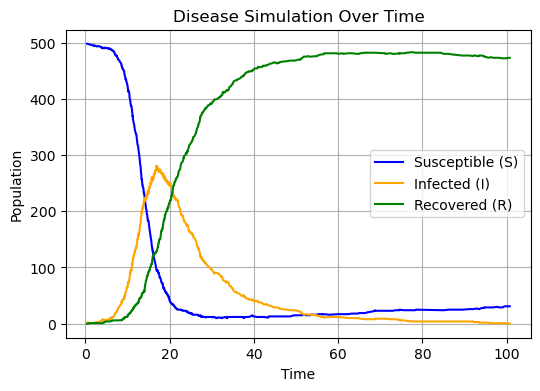

In [11]:
def run_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the disease simulation and plots the results.

    Parameters:
        N (int): Total population.
        X_0 (int): Initial susceptible population.
        Y_0 (int): Initial infected population.
        Z_0 (int): Initial recovered population.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        mu (float): Natural birth/death rate.
        t_span (int): Duration of the simulation.
    """

    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parameters
N = 500
S = N - 1
I = N - S
R = 0

beta = 0.6
gamma = 0.1
mu = 0.001


t_span = 100

sir = [S, I, R, N]

run_simulation(sir, beta, gamma, mu, t_span)


## Run Deterministic Model

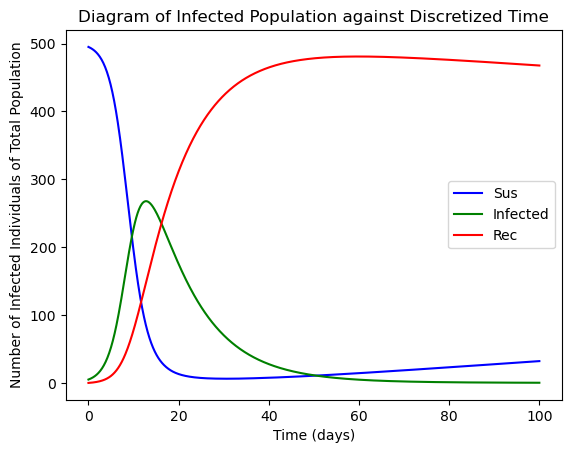

In [12]:
# simulation parameters
beta = 0.6
gamma = 0.1
birth = 0.001
death = 0.001

parameters = [beta, gamma, birth, death]

t_span = 100

# Initial conditions with 99% susceptible, 1% infected and 0% recovered and a population of 100 people
S0 = 0.99
I0 = 0.01
R0 = 0
N = 500

# Creates a list of initial condition values
initial_conditions = [S0 * N, I0 * N, R0 * N]

# Calculates the ODEs and returns as a list
def calc_ode(t, sir, parameters, N):
    beta, gamma, birth, death = parameters
    sus, inf, rec = sir
    dSdt = birth*N - ((beta * sus * inf)/ N) - (death * sus)
    dIdt = ((beta * sus * inf) / N) - (gamma * inf) - (death * inf)
    dRdt = (gamma * inf) - (death * rec)
    return [dSdt, dIdt, dRdt]

def plot_sir_ode(time, S, I, R):
    # Plots results
    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='g')
    plt.plot(time, R, label='Rec', color='r')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Infected Population against Discretized Time')
    plt.show()

def run_sir_ode(sir, N, parameters, t_span):
    # Creates an array for each time measurement with 1600 samples, equally spaced between 0 and 1000
    time = np.linspace(0, t_span, 1000)

    # Solves for epidemic scenario with scipy.integrate function solove_ivp: 
    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, args=(parameters, N), t_eval=time)

    # Assigns y values of sir_integration to correct labels, for later plotting
    S, I, R = sir_integration.y

    plot_sir_ode(time, S, I, R)

run_sir_ode(initial_conditions, N, parameters, t_span)

## Look at variance

In [ ]:
def variance():
    print("Huhuhaha")